In [1]:
import numpy as np
import random


def bitflip_mutation(population, mutation_probability):
    n_samples, n_features = population.shape
    for i in range(n_samples):
        if np.random.rand() < mutation_probability:
            random_index = np.random.randint(n_features)
            population[i, random_index] = 1 - population[i, random_index]
    
    return population


def one_point_crossover(population, crossover_probability):
    n_samples, n_features = population.shape
    offsprings = []
    for _ in range(0, n_samples):
        if np.random.rand() < crossover_probability:
            i, j = np.random.choice(n_samples, 2, replace=False)
            random_index = np.random.randint(n_features)
            offsprings.append(np.concatenate([population[i, :random_index], population[j, random_index:]]))
            offsprings.append(np.concatenate([population[j, :random_index], population[i, random_index:]]))
        
    return np.array(offsprings)


def roulette_wheel_selection(population, fitness_func, n_samples, temperature=1.0):
    fitness = np.array([fitness_func(individual) for individual in population])
    weights = fitness ** (1/temperature)
    indices = np.random.choice(len(population), n_samples, p=weights/weights.sum())
    best_idx = np.argmax(fitness[indices])
    return population[indices], fitness[indices].mean(), fitness[indices].max(), population[indices[best_idx]]


def genetic_algorithm(
    fitness_func,
    max_iter=100,
    population_size=100,
    n=25,
    mutation_probability=0.2,
    crossover_probability = 0.8,
    temperature=1.0,
    random_state=None,
    verbose=False
):
    if random_state is not None:
        np.random.seed(random_state)
        random.seed(random_state)
    
    generation = np.random.randint(0, 2, (population_size, n))
    history_mean, history_max = [], []

    for _ in range(max_iter):
        offsprings = one_point_crossover(generation, crossover_probability)
        offsprings = bitflip_mutation(offsprings, mutation_probability)
        generation, fitness_mean, fitness_max, best_sample = roulette_wheel_selection(offsprings, fitness_func, population_size, temperature)
        history_mean.append(fitness_mean)
        history_max.append(fitness_max)
        if verbose:
            print(f'Generation: {len(history_mean)}, Fitness: {fitness_mean:.2f}, Best Fitness: {fitness_max:.2f}')
    
    return generation, history_mean, history_max, best_sample

In [2]:
import pandas as pd
from tqdm import trange

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

def experiment(fitness_func, n_repeats, **kwargs):
    results = pd.Series()
    for rs in trange(n_repeats):
        _, history_mean, history_max, best_sample = genetic_algorithm(fitness_func, **kwargs, random_state=rs)
        results = pd.concat([results, pd.Series(history_max, index=np.arange(len(history_max)))])

    print(f"Best sample: {best_sample}")

    return results
    

def plot_results(results, title):
    sns.lineplot(data=results)
    plt.xlabel('Generation')
    plt.ylabel('Max Fitness')
    plt.title(title)
    plt.show()

# OneMax

In [3]:
def onemax_fitness(x):
    return x.sum()

results = experiment(
    onemax_fitness,
    n_repeats=10,
    max_iter=100
)

100%|██████████| 10/10 [00:00<00:00, 11.09it/s]

Best sample: [1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1]


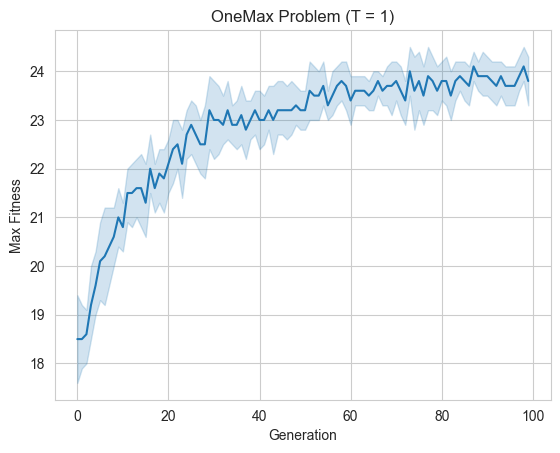

In [4]:
plot_results(results, "OneMax Problem (T = 1)")

In [5]:
results = experiment(
    onemax_fitness,
    n_repeats=10,
    max_iter=100,
    temperature=0.3
)

100%|██████████| 10/10 [00:00<00:00, 10.70it/s]

Best sample: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


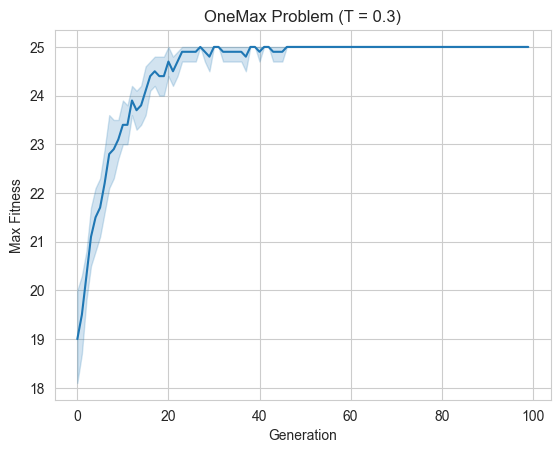

In [6]:
plot_results(results, "OneMax Problem (T = 0.3)")

# Alternating Bits

In [7]:
def alt_fitness(x):
    template_1 = np.ones_like(x)
    template_1[::2] = 0

    template_2 = np.zeros_like(x)
    template_2[::2] = 1

    return max(
        ((x - template_1) ** 2).sum(),
        ((x - template_2) ** 2).sum()
    )

results = experiment(
    alt_fitness,
    n_repeats=10,
    max_iter=100
)

100%|██████████| 10/10 [00:01<00:00,  5.93it/s]

Best sample: [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 1 0 1 0 1]


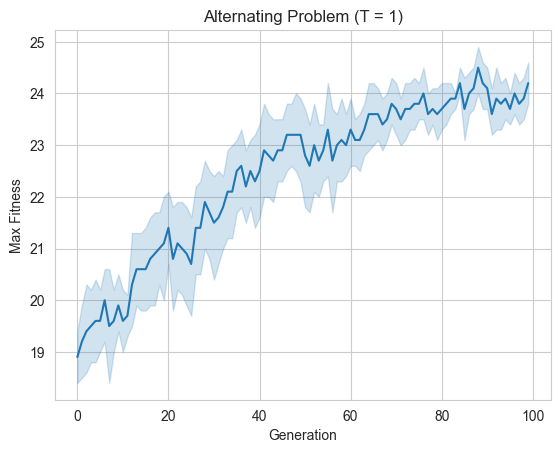

In [8]:
plot_results(results, "Alternating Problem (T = 1)")

100%|██████████| 10/10 [00:01<00:00,  6.27it/s]


Best sample: [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1]


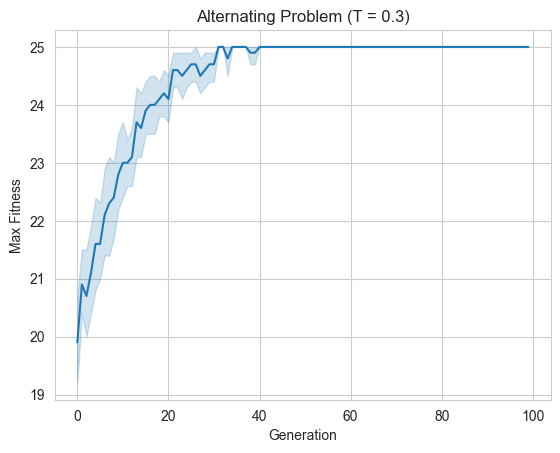

In [9]:
results = experiment(
    alt_fitness,
    n_repeats=10,
    max_iter=100,
    temperature=0.3
)

plot_results(results, "Alternating Problem (T = 0.3)")

## Playing with parameters

In [10]:
param_sets = [
    {"temperature": 1, "mutation_probability": 0.2, "crossover_probability": 0.8},
    {"temperature": 1, "mutation_probability": 0.2, "crossover_probability": 0.8, "population_size": 500},
    {"temperature": 1, "mutation_probability": 0.0, "crossover_probability": 0.8},
]

param_sets_03 = [
    {"temperature": 0.3, "mutation_probability": 0.2, "crossover_probability": 0.8},
    {"temperature": 0.3, "mutation_probability": 0.2, "crossover_probability": 0.8, "population_size": 500},
    {"temperature": 0.3, "mutation_probability": 0.0, "crossover_probability": 0.8},
]

res_1, res_03 = [], []
for params in param_sets:
    results = experiment(
        alt_fitness,
        n_repeats=10,
        **params
    )
    res_1.append(results)

for params in param_sets_03:
    results = experiment(
        alt_fitness,
        n_repeats=10,
        **params
    )
    res_03.append(results)

100%|██████████| 10/10 [00:01<00:00,  6.13it/s]


Best sample: [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 1 0 1 0 1]


100%|██████████| 10/10 [00:09<00:00,  1.11it/s]


Best sample: [0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0]


100%|██████████| 10/10 [00:01<00:00,  6.60it/s]


Best sample: [1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 0 1 0 1 0 1 0 1 1 1]


100%|██████████| 10/10 [00:01<00:00,  6.34it/s]


Best sample: [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1]


100%|██████████| 10/10 [00:09<00:00,  1.09it/s]


Best sample: [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1]


100%|██████████| 10/10 [00:01<00:00,  6.52it/s]

Best sample: [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1]


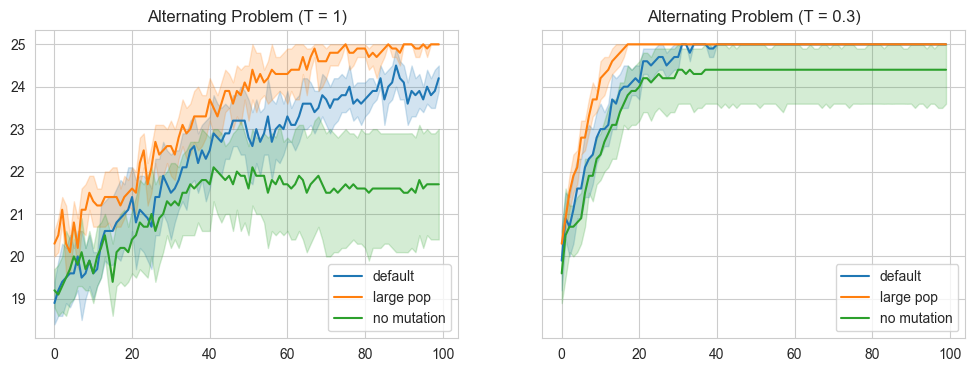

In [11]:
f, ax = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

param_labels = ["default", "large pop", "no mutation"]

for i, results in enumerate(res_1):
    sns.lineplot(data=results, ax=ax[0], label=param_labels[i])
ax[0].set_title("Alternating Problem (T = 1)")
ax[0].legend(loc="lower right")

for i, results in enumerate(res_03):
    sns.lineplot(data=results, ax=ax[1], label=param_labels[i])
ax[1].set_title("Alternating Problem (T = 0.3)")
ax[1].legend(loc="lower right");